<a href="https://colab.research.google.com/github/covalenzuela/RRNN/blob/main/code_tarea2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este documento contine el desarrollo computacional de la segunda evaluacion del curso de Redes Neuronales de la UCM (septiembre 2024 - enero 2025) impartido por el profesor Marcos Mora mmora@ucm.cl y la profesora Karina Vilches
kvilches@ucm.cl, junto a Yoleidy Huerfano-Maldonado (yoleidy.huerfano@alu.ucm.cl) la pro de deep learning en modelo semisupervisado.

# **TAREA 2: Entrenamiento Método no supervisado**



## **Requerimientos**
---
Considerando la base datos MNIST de la Tarea Nº1, realizar un entrenamiento no supervisado (*clustering*) para agrupar los digitos presentes en la base de datos. Para el clustering, utilice el algoritmo ***Unsupervised Extreme Learning Machine (US-ELM)*** estudiado en clase.

Se debe realizar experimentos con los algoritmos *k-means* y *US-ELM* (usando *k-means*), y realizar una comparación de la performance de agrupamiento mediante al menos 2 métricas para medir la calidad del clustering (por ejemplo: https://keepcoding.io/blog/medir-la-calidad-de-un-cluster/ o https://www.geeksforgeeks.org/clustering-metrics/), siendo una de ellas el *Accuracy*. Además ha de utilizar una comparación de tiempo considerando el ***tiempo de computo de la transformación*** y el ***tiempo de agrupamiento***.

## **Data Set**
---
MNIST (Modified National Institute of Standards and Technology) es un conjunto de datos de imágenes de dígitos (caracteres numéricos del 0 al 9) escritos a mano. Se utiliza para entrenar sistemas de procesamiento de imágenes y modelos de aprendizaje automático.

**Características**
- Contiene *70,000 imágenes* en escala de grises de ***28 x 28 píxeles***
- Se divide en ***60,000 imágenes de entrenamiento*** y ***10,000 imágenes de prueba/test***
- Las ***imágenes están etiquetadas*** con los dígitos escritos a mano (***del 0 al 9***)
- Es una referencia para evaluar el rendimiento de los algoritmos de clasificación de imágenes

**Usos**
- Se utiliza para entrenar y evaluar modelos de aprendizaje profundo en tareas de clasificación de imágenes
- Es un recurso esencial para investigadores y profesionales en el campo del aprendizaje automático y la visión por computadora

**Creacón**
- Se creó a partir de las muestras de los conjuntos de datos originales del NIST (https://docs.ultralytics.com/es/datasets/classify/mnist/#key-features)
- Las imágenes originales se normalizaron para que cupieran en un grid de 20x20 píxeles, y luego se centraron en un grid de 28x28 píxeles

### **Cargar librerias**

In [ ]:
# librerias
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from scipy.linalg import pinv, inv



### **Cargar datos**
aaa
dataset descargado desde https://github.com/cvdfoundation/mnist?tab=readme-ov-file con 60k ejemplos para entrenamiento y 10k ejemplos para pruebas
y almacenado de forma local (https://github.com/tensorflow/datasets/blob/master/tensorflow_datasets/image_classification/mnist.py)


In [ ]:
import tensorflow as tf

# Cargar Datos MNIST
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Información del dataset
#print(f'Train images shape: {train_images.shape}')  # (60000, 28, 28)
#print(f'Test images shape: {test_images.shape}')    # (10000, 28, 28)

#print(f'Train labels shape: {train_labels.shape}')  # (60000,)
#print(f'Test labels shape: {test_labels.shape}')    # (10000,)


### **Pre-Process**

#### **Normalizacion de datos**
Luego de la descarga de los datos se realiza la normalizacion de estos y su division en los conjuntos de entrenamiento, testeo y validacion:

In [ ]:
# Aplanar las imágenes de 28x28 a 784 elementos
train_images = train_images.reshape((train_images.shape[0], 28 * 28)).astype('float32')
test_images = test_images.reshape((test_images.shape[0], 28 * 28)).astype('float32')

# Normalizar las imágenes a un rango [0, 1]
train_images /= 255.0
test_images /= 255.0


#### **División en conjuntos de datos**
Separar los datos en tres conjuntos es crucial cuando estamos ajustando modelos y seleccionando hiperparámetros. En particular cada conjunto permite:
*   **Entrenamiento/Train**:
    - Para ajustar el modelo a los datos.
*   **Validación/Validation**:
    -   Para seleccionar los mejores hiperparámetros y evitar sobreajuste.
    -   Si solo se usaran datos de entrenamiento y prueba, podríamos ajustar los hiperparámetros sobre el conjunto de prueba, lo que invalidaría su función como una métrica imparcial del desempeño del modelo.
*   **Prueba/Test**:
    -   Para evaluar el rendimiento final del modelo en datos nunca vistos, proporcionando una métrica objetiva de su generalización.

##### *Proporciones de conjuntos*
La división de los datos en las proporciones mostradas (50,000 para entrenamiento, 10,000 para validación, y 10,000 para prueba) se basa en varias prácticas comunes y objetivos del aprendizaje automático:
*   **Entrenamiento (50,000 muestras)**:
  
  Este conjunto debe ser lo suficientemente grande como para permitir que el modelo aprenda las características generales de los datos.
  - Un 80-90% de los datos disponibles se asigna comúnmente al entrenamiento en problemas supervisados.

*   **Validación (10,000 muestras)**:
  
  Este conjunto permite evaluar y ajustar los hiperparámetros del modelo (por ejemplo, número de neuronas ocultas, regularización).
  - El 10-20% de los datos suele reservarse para validación.
  - En problemas más complejos, una mayor proporción (hasta el 20%) puede ser dedicada a validación para asegurar una evaluación robusta.

*   **Prueba (10,000 muestras)**:

  El conjunto de prueba se reserva para una evaluación final del modelo.
  - Generalmente, ocupa entre el 10-20% de los datos y debe mantenerse separado del proceso de entrenamiento y ajuste para asegurar una evaluación objetiva.

*Fundamento de estas proporciones*

* Tamaño de los conjuntos: MNIST tiene un total de 70,000 muestras. Dividirlo en proporciones como 80/10/10 es una práctica común porque
  - Hay suficientes datos para entrenar el modelo.
  - La validación y la prueba tienen datos representativos para medir el rendimiento.
* Evitar sobreajuste: Al incluir un conjunto de validación, se evita usar el conjunto de prueba durante el ajuste, lo que podría sesgar la evaluación del rendimiento final.

Si el problema no implica ajustar hiperparámetros, el conjunto de validación puede omitirse y los datos dividirse en 80/20 (entrenamiento y prueba). Sin embargo, para tareas complejas como clustering con US-ELM y K-Means, esta separación en tres conjuntos es más robusta.

In [ ]:
# Dividir los datos en conjunto de entrenamiento y validación
# (antes)
#x_train, x_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# (ahora)
validation_size = 10000
train_size = len(train_images) - validation_size

x_train, x_val, y_train, y_val = train_test_split(
    train_images, train_labels,
    test_size=validation_size,
    train_size=train_size,
    random_state=42
)

# Información de las divisiones
print(f'x_train shape: {x_train.shape}, y_train shape: {y_train.shape}')  # (50000, 784), (50000,)
print(f'x_val shape: {x_val.shape}, y_val shape: {y_val.shape}')          # (10000, 784), (10000,)
print(f'x_test shape: {test_images.shape}, y_test shape: {test_labels.shape}')  # (10000, 784), (10000,)

x_train shape: (50000, 784), y_train shape: (50000,)
x_val shape: (10000, 784), y_val shape: (10000,)
x_test shape: (10000, 784), y_test shape: (10000,)


## **Configuracion de Algoritmos**
---
### Métricas para clustering
1.   Accuracy (usando correspondencia de clúster a etiqueta)
  - **Qué mide**: La proporción de ejemplos correctamente asignados al clúster correspondiente a su etiqueta real.
  - **Ventaja**: Es fácil de interpretar.
  - **Limitación**: Requiere correspondencia entre clústeres y etiquetas, lo cual puede ser un paso adicional.

2.   Normalized Mutual Information (NMI)
  - **Qué mide**: Cuantifica la información mutua normalizada entre los clústeres predichos y las etiquetas reales.
  - **Ventaja**: Es independiente del número de clústeres y etiquetas, y tiene valores entre 0 y 1 (donde 1 es una correspondencia perfecta).
  - **Limitación**: Es menos intuitivo que el Accuracy para interpretar.

3.   Silhouette Score
  - **Qué mide**: La calidad de los clústeres basada en la distancia entre puntos dentro del mismo clúster (cohesión) y entre diferentes clústeres (separación).
  - **Ventaja**: Es independiente de las etiquetas reales y refleja la estructura intrínseca de los datos.
  - **Limitación**: Requiere que el modelo esté bien escalado para ser representativo.

*Motivación para elegir estas métricas:*
*   *Accuracy* y *NMI*: Son ideales cuando se dispone de etiquetas reales, ya que miden cómo el clustering se alinea con las etiquetas conocidas.
*   *Silhouette Score*: Complementa las métricas supervisadas al analizar la estructura del clustering desde una perspectiva puramente geométrica.



### ***1. Clustering con K-means***


In [ ]:
#import time
#import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, normalized_mutual_info_score, silhouette_score
from scipy.optimize import linear_sum_assignment

# Función para calcular Accuracy ajustada a etiquetas reales
def clustering_accuracy(y_true, y_pred):
    # Encontrar la mejor correspondencia entre clusters y etiquetas reales
    cost_matrix = np.zeros((10, 10))
    for i in range(10):
        for j in range(10):
            cost_matrix[i, j] = -np.sum((y_pred == i) & (y_true == j))
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    mapping = dict(zip(row_ind, col_ind))
    y_pred_mapped = np.array([mapping[label] for label in y_pred])
    return accuracy_score(y_true, y_pred_mapped)

# Medir tiempo para ajuste y predicción con K-Means
start_time_fit = time.time()
#kmeans = KMeans(n_clusters=10, random_state=42)
kmeans = KMeans(n_clusters=10, n_init=10, random_state=42)  # Permitir inicializaciones aleatorias con random None
kmeans.fit(x_train)
fit_time = time.time() - start_time_fit

start_time_predict = time.time()
y_pred = kmeans.predict(x_train)
predict_time = time.time() - start_time_predict

# Métricas de rendimiento para entrenamiento
accuracy = clustering_accuracy(y_train, y_pred)
nmi = normalized_mutual_info_score(y_train, y_pred)
silhouette = silhouette_score(x_train, y_pred)

print("\n--- Entrenamiento ---")
print(f"K-Means Accuracy: {accuracy:.4f}")
print(f"K-Means NMI: {nmi:.4f}")
print(f"K-Means Silhouette Score: {silhouette:.4f}")
print(f"Time for K-Means fit: {fit_time:.4f} seconds")
print(f"Time for K-Means predict (training): {predict_time:.4f} seconds")

# Predicciones para prueba
start_time_test_predict = time.time()
y_test_pred = kmeans.predict(test_images)
test_predict_time = time.time() - start_time_test_predict

# Métricas para prueba
test_accuracy = clustering_accuracy(test_labels, y_test_pred)
test_nmi = normalized_mutual_info_score(test_labels, y_test_pred)
test_silhouette = silhouette_score(test_images, y_test_pred)

print("\n--- Prueba ---")
print(f"K-Means Test Accuracy: {test_accuracy:.4f}")
print(f"K-Means Test NMI: {test_nmi:.4f}")
print(f"K-Means Test Silhouette Score: {test_silhouette:.4f}")
print(f"Time for K-Means predict (test): {test_predict_time:.4f} seconds")

# Predicciones para validación
start_time_val_predict = time.time()
y_val_pred = kmeans.predict(x_val)
val_predict_time = time.time() - start_time_val_predict

# Métricas para validación
val_accuracy = clustering_accuracy(y_val, y_val_pred)
val_nmi = normalized_mutual_info_score(y_val, y_val_pred)
val_silhouette = silhouette_score(x_val, y_val_pred)

print("\n--- Validación ---")
print(f"K-Means Validation Accuracy: {val_accuracy:.4f}")
print(f"K-Means Validation NMI: {val_nmi:.4f}")
print(f"K-Means Validation Silhouette Score: {val_silhouette:.4f}")
print(f"Time for K-Means predict (validation): {val_predict_time:.4f} seconds")



--- Entrenamiento ---
K-Means Accuracy: 0.5284
K-Means NMI: 0.4970
K-Means Silhouette Score: 0.0588
Time for K-Means fit: 34.3470 seconds
Time for K-Means predict (training): 0.0223 seconds

--- Prueba ---
K-Means Test Accuracy: 0.5408
K-Means Test NMI: 0.5084
K-Means Test Silhouette Score: 0.0617
Time for K-Means predict (test): 0.0079 seconds

--- Validación ---
K-Means Validation Accuracy: 0.5261
K-Means Validation NMI: 0.4970
K-Means Validation Silhouette Score: 0.0577
Time for K-Means predict (validation): 0.0074 seconds


In [ ]:
# Crear una lista con los resultados de K-Means
kmeans_results = [
    {
        "Dataset": "Entrenamiento",
        "Accuracy": accuracy,
        "NMI": nmi,
        "Silhouette Score": silhouette,
        "Fit Time": fit_time,
        "Predict Time": predict_time,
        "Total Time": fit_time + predict_time
    },
    {
        "Dataset": "Validación",
        "Accuracy": val_accuracy,
        "NMI": val_nmi,
        "Silhouette Score": val_silhouette,
        "Fit Time": 0,  # No hay tiempo de ajuste adicional en validación
        "Predict Time": val_predict_time,
        "Total Time": val_predict_time
    },
    {
        "Dataset": "Prueba",
        "Accuracy": test_accuracy,
        "NMI": test_nmi,
        "Silhouette Score": test_silhouette,
        "Fit Time": 0,  # No hay tiempo de ajuste adicional en prueba
        "Predict Time": test_predict_time,
        "Total Time": test_predict_time
    }
]

# Convertir los resultados a un DataFrame para visualizar
kmeans_results_df = pd.DataFrame(kmeans_results)

# Mostrar la tabla
print("\nResultados finales:")
print(kmeans_results_df)



Resultados finales:
         Dataset  Accuracy       NMI  Silhouette Score   Fit Time  \
0  Entrenamiento   0.52836  0.496953          0.058805  34.347043   
1     Validación   0.52610  0.497028          0.057680   0.000000   
2         Prueba   0.54080  0.508438          0.061739   0.000000   

   Predict Time  Total Time  
0      0.022337   34.369380  
1      0.007407    0.007407  
2      0.007889    0.007889  


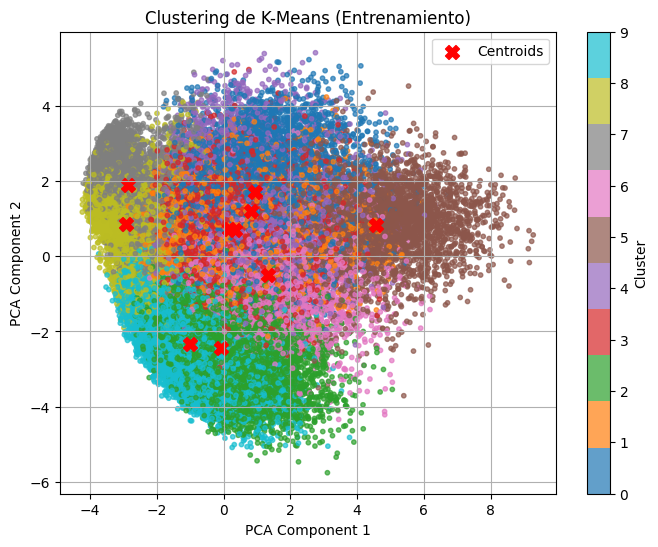

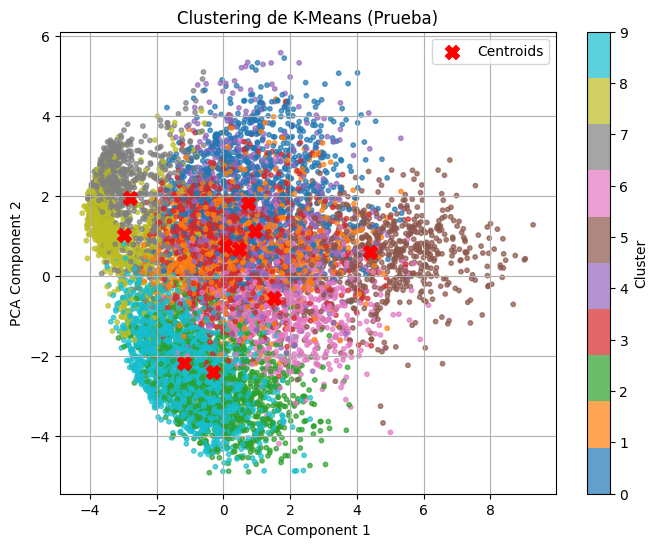

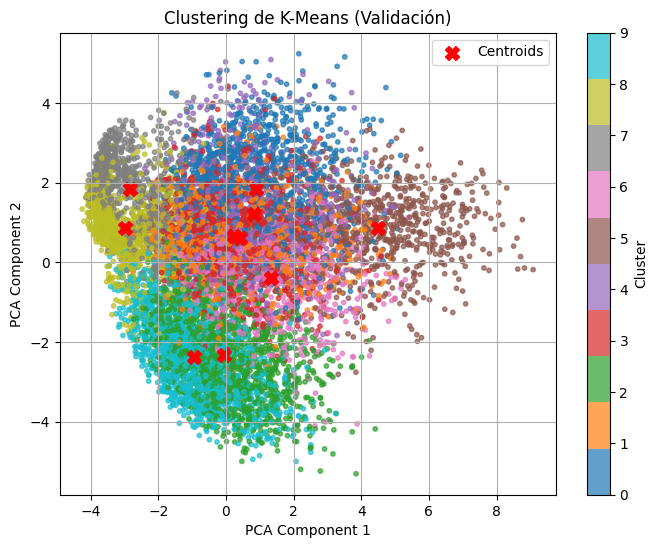

In [ ]:
#import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Función para graficar el clustering
def plot_clusters(data, labels, centroids, title):
    # Reducir la dimensionalidad con PCA
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)
    reduced_centroids = pca.transform(centroids)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='tab10', s=10, alpha=0.7)
    plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], c='red', marker='X', s=100, label='Centroids')
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.colorbar(scatter, label='Cluster')
    plt.grid()
    plt.show()

# Calcular los centroides del modelo ajustado
centroids = kmeans.cluster_centers_

# Graficar resultados para entrenamiento
plot_clusters(x_train, y_pred, centroids, title="Clustering de K-Means (Entrenamiento)")

# Graficar resultados para prueba
print("\n")
plot_clusters(test_images, y_test_pred, centroids, title="Clustering de K-Means (Prueba)")

# Graficar resultados para validación
print("\n")
plot_clusters(x_val, y_val_pred, centroids, title="Clustering de K-Means (Validación)")


### ***2. US-ELM (usando k-means)***
Proceso:

**1.   Transformación de los datos:** Los datos de entrada se transforman en un nuevo espacio de características utilizando una red ELM.

**2.   Construcción del grafo Laplaciano:** Se construye un grafo con la librería scipy que representa las relaciones entre los puntos de datos en el espacio de características.

**3.   Cálculo de los autovectores generalizados:** Se calculan los autovectores generalizados de la matriz laplaciana para obtener una representación de baja dimensión de los datos.

**4.   Clustering:** Se aplica un algoritmo de clustering tradicional (como k-means de scikit-learn) a la representación de baja dimensión para agrupar los datos.

**5.   Evaluación**: Se aplican las métricas definidas anteriormente (Accuracy, NMI, Silhouette).

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, normalized_mutual_info_score, silhouette_score
from scipy.linalg import eigh  # Para eigenvectores
from scipy.sparse.csgraph import laplacian
from scipy.optimize import linear_sum_assignment
import time

# Función para calcular Accuracy ajustada
def clustering_accuracy(y_true, y_pred):
    cost_matrix = np.zeros((10, 10))
    for i in range(10):
        for j in range(10):
            cost_matrix[i, j] = -np.sum((y_pred == i) & (y_true == j))
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    mapping = dict(zip(row_ind, col_ind))
    y_pred_mapped = np.array([mapping[label] for label in y_pred])
    return accuracy_score(y_true, y_pred_mapped)

# Función de activación (sigmoide)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# --- Stage 1: Data Transformation ---
from sklearn.neighbors import kneighbors_graph

def us_elm_data_transformation(X, hidden_neurons, n_clusters):
    print("\n--- Stage 1: Data Transformation ---")

    # Paso 1: Construcción del grafo Laplaciano L
    print("Construyendo el grafo Laplaciano...")
    adjacency_matrix = kneighbors_graph(X, n_neighbors=10, include_self=False).toarray()
    L = laplacian(adjacency_matrix, normed=True)

    # Paso 2: Inicialización de la red ELM (pesos aleatorios y biases)
    print("Inicializando la red ELM...")
    input_dim = X.shape[1]
    input_weights = np.random.uniform(-1, 1, size=(hidden_neurons, input_dim))
    biases = np.random.uniform(-1, 1, size=(hidden_neurons,))

    # Paso 3: Calcular salidas de la capa oculta (H)
    print("Calculando transformaciones de la capa oculta...")
    H = sigmoid(np.dot(X, input_weights.T) + biases)

    # Paso 4: Calcular eigenvectores del grafo Laplaciano
    print("Calculando eigenvectores para la transformación...")
    eigvals, eigvecs = eigh(L, subset_by_index=[0, n_clusters - 1])

    # Ajustar beta para que tenga dimensiones (n_hidden, n_clusters)
    print("Ajustando los eigenvectores...")
    eigvecs_reduced = eigvecs[:, :n_clusters]  # (N, n_clusters)
    beta = np.dot(H.T, eigvecs_reduced)       # (n_hidden, n_clusters)

    # Obtener matriz de embedding E
    print("Calculando matriz de embedding E...")
    E = np.dot(H, beta)  # (N, n_clusters)

    return E

# --- Stage 2: Clustering of Transformed Data ---
def us_elm_clustering(E, y_true, n_clusters):
    print("\n--- Stage 2: Clustering of Transformed Data ---")

    # Paso 5: Realizar clustering usando K-Means
    print("Aplicando K-Means sobre E...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(E)
    y_pred = kmeans.labels_

    # Evaluar métricas de rendimiento
    accuracy = clustering_accuracy(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    silhouette = silhouette_score(E, y_pred)

    return accuracy, nmi, silhouette

# Ejecución completa de US-ELM
def run_us_elm(X, y_true, hidden_neurons, n_clusters=10):
    # --- Transformación de datos ---
    start_transform = time.time()
    E = us_elm_data_transformation(X, hidden_neurons, n_clusters)
    transform_time = time.time() - start_transform

    # --- Clustering de los datos transformados ---
    start_clustering = time.time()
    accuracy, nmi, silhouette = us_elm_clustering(E, y_true, n_clusters)
    clustering_time = time.time() - start_clustering

    return {
        "Accuracy": accuracy,
        "NMI": nmi,
        "Silhouette Score": silhouette,
        "Transform Time": transform_time,
        "Clustering Time": clustering_time
    }

# --- Pruebas con los conjuntos de datos ---
datasets = {
    "Entrenamiento": (x_train, y_train),
    "Validación": (x_val, y_val),
    "Prueba": (test_images, test_labels),
}

hidden_neurons_list = [50, 100, 200, 500, 1000, 2000, 5000]
results = []

for hidden_neurons in hidden_neurons_list:
    for dataset_name, (X, y) in datasets.items():
        print(f"\n=== US-ELM con {hidden_neurons} Neuronas Ocultas en {dataset_name} ===")
        result = run_us_elm(X, y, hidden_neurons)
        result.update({
            "Hidden Neurons": hidden_neurons,
            "Dataset": dataset_name
        })
        results.append(result)




=== US-ELM con 50 Neuronas Ocultas en Entrenamiento ===

--- Stage 1: Data Transformation ---
Construyendo el grafo Laplaciano...
Inicializando la red ELM...
Calculando transformaciones de la capa oculta...
Calculando eigenvectores para la transformación...
Ajustando los eigenvectores...
Calculando matriz de embedding E...

--- Stage 2: Clustering of Transformed Data ---
Aplicando K-Means sobre E...

=== US-ELM con 50 Neuronas Ocultas en Validación ===

--- Stage 1: Data Transformation ---
Construyendo el grafo Laplaciano...
Inicializando la red ELM...
Calculando transformaciones de la capa oculta...
Calculando eigenvectores para la transformación...
Ajustando los eigenvectores...
Calculando matriz de embedding E...

--- Stage 2: Clustering of Transformed Data ---
Aplicando K-Means sobre E...

=== US-ELM con 50 Neuronas Ocultas en Prueba ===

--- Stage 1: Data Transformation ---
Construyendo el grafo Laplaciano...
Inicializando la red ELM...
Calculando transformaciones de la capa ocul

Presentando la informacion de las ejecuciones con los distintos parametros evaluados:

In [ ]:
# Mostrar resultados en forma de tabla
#import pandas as pd
results_df = pd.DataFrame(results)
# Agregar tiempo total a la tabla results_df
results_df['Total Time'] = results_df['Transform Time'] + results_df['Clustering Time']
print("\nResultados finales:")
print(results_df)



Resultados finales:
    Accuracy       NMI  Silhouette Score  Transform Time  Clustering Time  \
0    0.17780  0.056928          0.164305     3041.826939        28.755745   
1    0.20430  0.102113          0.224801       23.953130         3.665630   
2    0.21550  0.111284          0.192427       23.690407         3.644961   
3    0.29862  0.208439          0.181563     3041.660597        28.628268   
4    0.21640  0.123800          0.192950       23.136290         3.618876   
5    0.19390  0.112236          0.177515       23.240094         3.401793   
6    0.25020  0.157725          0.165344     3045.842359        28.263827   
7    0.20270  0.096651          0.179546       23.977240         3.683090   
8    0.24090  0.150652          0.194034       23.150130         3.513080   
9    0.26230  0.174714          0.161889     3048.939528        28.518588   
10   0.24660  0.176218          0.188393       24.424696         3.657473   
11   0.38870  0.294112          0.185449       24.31474

#### **Análisis grafico**
1.   Graficos de Precision vs Tiempo

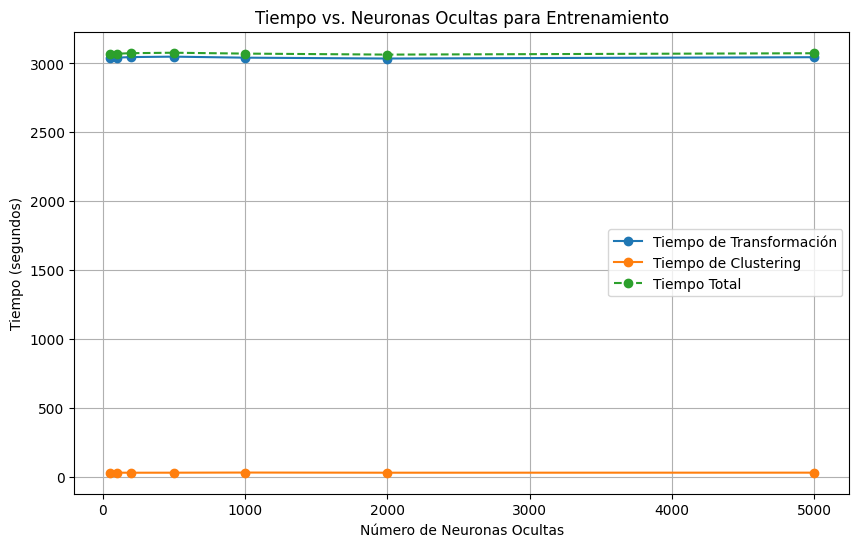

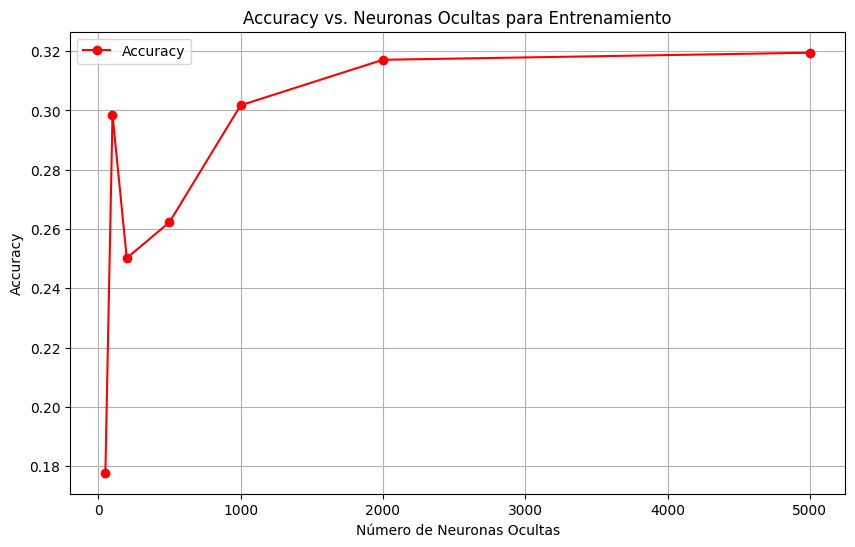

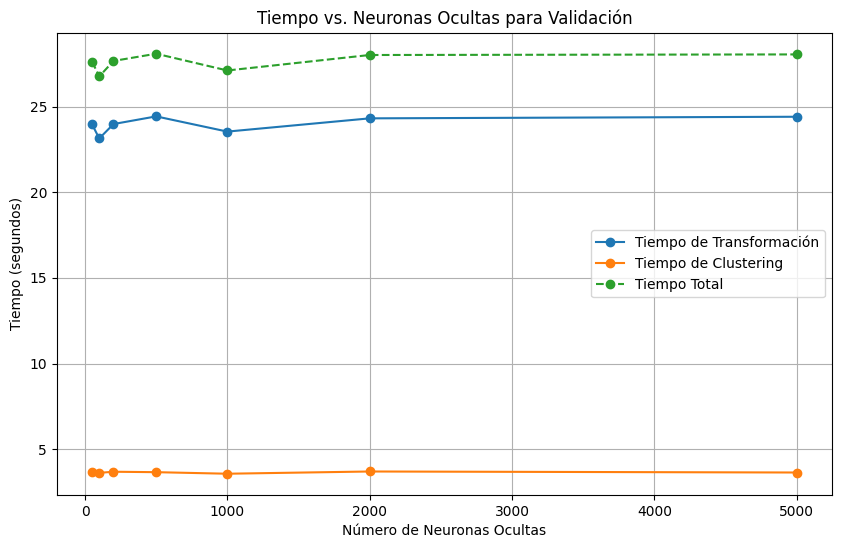

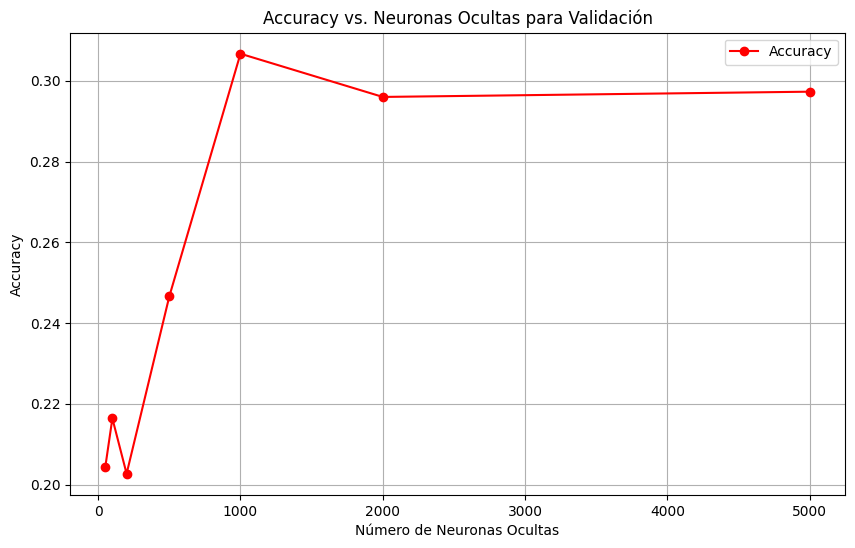

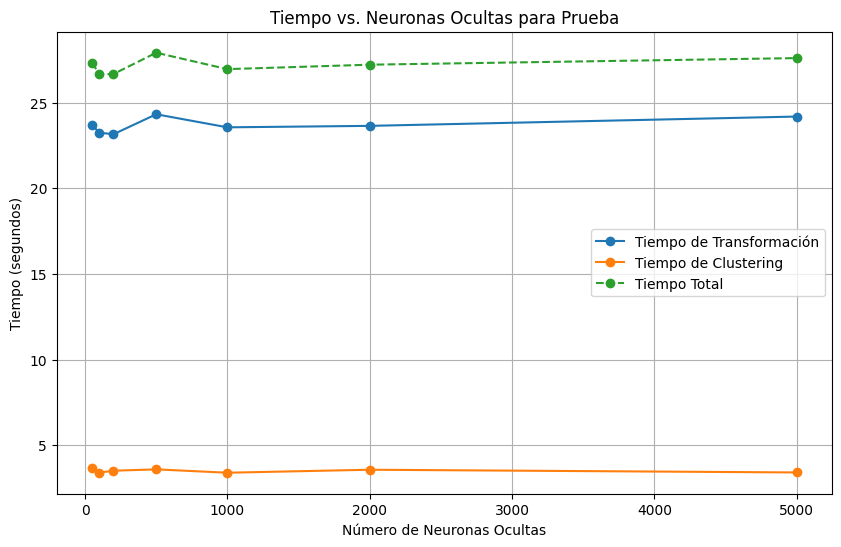

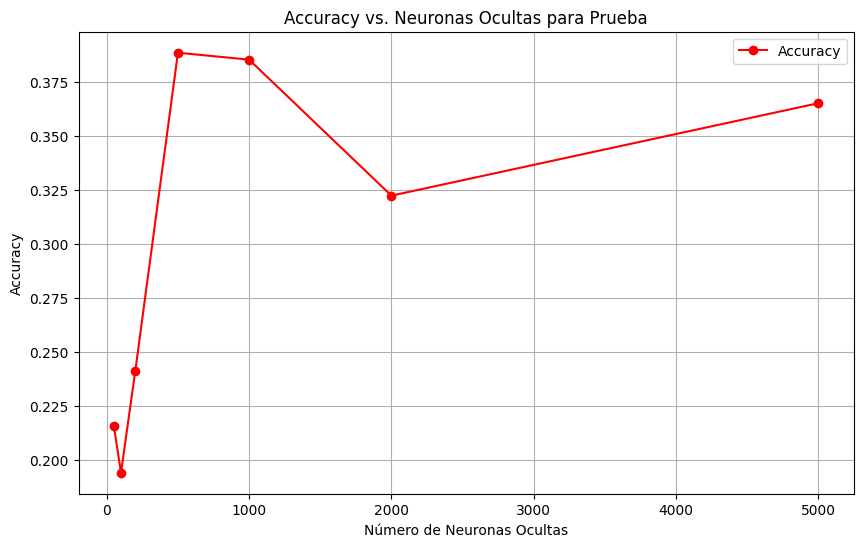

In [ ]:
#import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

datasets_unique = results_df['Dataset'].unique()

# Graficar Tiempo vs. Número de Neuronas Ocultas y Accuracy vs. Número de Neuronas Ocultas
for dataset_name in datasets_unique:
    subset = results_df[results_df['Dataset'] == dataset_name]

    # --- Gráfico: Tiempo vs. Número de Neuronas Ocultas ---
    plt.figure(figsize=(10, 6))
    plt.plot(subset['Hidden Neurons'], subset['Transform Time'], label='Tiempo de Transformación', marker='o')
    plt.plot(subset['Hidden Neurons'], subset['Clustering Time'], label='Tiempo de Clustering', marker='o')
    plt.plot(subset['Hidden Neurons'], subset['Total Time'], label='Tiempo Total', linestyle='--', marker='o')
    plt.title(f"Tiempo vs. Neuronas Ocultas para {dataset_name}")
    plt.xlabel("Número de Neuronas Ocultas")
    plt.ylabel("Tiempo (segundos)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Gráfico: Accuracy vs. Número de Neuronas Ocultas ---
    plt.figure(figsize=(10, 6))
    plt.plot(subset['Hidden Neurons'], subset['Accuracy'], label='Accuracy', marker='o', color='red')
    plt.title(f"Accuracy vs. Neuronas Ocultas para {dataset_name}")
    plt.xlabel("Número de Neuronas Ocultas")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()



Gráfico 2: Clustering con centroides (US-ELM)

In [ ]:
def plot_clusters_with_centroids(X_transformed, y_pred, centroids, dataset_name, hidden_neurons):
    # Reducir dimensionalidad a 2D
    pca = PCA(n_components=2)
    X_2D = pca.fit_transform(X_transformed)

    # Reducir dimensionalidad de los centroides
    centroids_2D = pca.transform(centroids)

    # Graficar clusters
    plt.figure(figsize=(10, 6))
    plt.scatter(X_2D[:, 0], X_2D[:, 1], c=y_pred, cmap='tab10', s=10, alpha=0.6, label='Datos Clusterizados')
    plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1], c='red', marker='X', s=200, label='Centroides')
    plt.title(f"Clusters con Centroides para {dataset_name} (Neuronas Ocultas: {hidden_neurons})")
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.legend()
    plt.grid(True)
    plt.show()

# Generar gráficos de clustering para cada dataset
for dataset_name, (X, y) in datasets.items():
    # Tomar la configuración de número de neuronas oculta como ejemplo
    hidden_neurons = hidden_neurons_list[0]  # Puedes ajustar este valor

    # Obtener pesos y biases
    input_weights, biases = initialize_elm(X.shape[1], hidden_neurons)

    # Transformar datos
    X_transformed = elm_transform(X, input_weights, biases)

    # Clustering con K-Means
    kmeans = KMeans(n_clusters=10, random_state=42)
    kmeans.fit(X_transformed)

    # Obtener etiquetas y centroides
    y_pred = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # Graficar clusters
    plot_clusters_with_centroids(X_transformed, y_pred, centroids, dataset_name, hidden_neurons)


NameError: name 'initialize_elm' is not defined

## **Comparación de Algoritmos**
---
A continuacion se buscaran diferencias en las metricas de calidad y tiempo de ejecucion

In [ ]:
# Preparar la tabla de K-Means
kmeans_results_df["Algoritmo"] = "K-Means"
kmeans_results_df["Hidden Neurons"] = "No aplica"  # K-Means no tiene neuronas ocultas
kmeans_results_df = kmeans_results_df[
    ["Algoritmo", "Dataset", "Hidden Neurons", "Accuracy", "NMI", "Silhouette Score", "Fit Time", "Predict Time", "Total Time"]
]

# Preparar la tabla de US-ELM
results_df["Algoritmo"] = "US-ELM"
results_df.rename(columns={"Transform Time": "Fit Time", "Clustering Time": "Predict Time"}, inplace=True)
results_df["Total Time"] = results_df["Fit Time"] + results_df["Predict Time"]
results_df["Fit Time"] = results_df["Fit Time"].astype(float)  # Asegurar formato numérico
results_df["Predict Time"] = results_df["Predict Time"].astype(float)  # Asegurar formato numérico
results_df = results_df[
    ["Algoritmo", "Dataset", "Hidden Neurons", "Accuracy", "NMI", "Silhouette Score", "Fit Time", "Predict Time", "Total Time"]
]

# Combinar ambas tablas
comparison_results_df = pd.concat([kmeans_results_df, results_df], ignore_index=True)

# Mostrar la tabla combinada
print("\nComparación Resultados finales:")
print(comparison_results_df)



Comparación Resultados finales:
   Algoritmo        Dataset Hidden Neurons  Accuracy       NMI  \
0    K-Means  Entrenamiento      No aplica   0.52836  0.496953   
1    K-Means     Validación      No aplica   0.52610  0.497028   
2    K-Means         Prueba      No aplica   0.54080  0.508438   
3     US-ELM  Entrenamiento             50   0.17780  0.056928   
4     US-ELM     Validación             50   0.20430  0.102113   
5     US-ELM         Prueba             50   0.21550  0.111284   
6     US-ELM  Entrenamiento            100   0.29862  0.208439   
7     US-ELM     Validación            100   0.21640  0.123800   
8     US-ELM         Prueba            100   0.19390  0.112236   
9     US-ELM  Entrenamiento            200   0.25020  0.157725   
10    US-ELM     Validación            200   0.20270  0.096651   
11    US-ELM         Prueba            200   0.24090  0.150652   
12    US-ELM  Entrenamiento            500   0.26230  0.174714   
13    US-ELM     Validación            500 

**Graficos de Metricas**

Index(['Algoritmo', 'Dataset', 'Hidden Neurons', 'Accuracy', 'NMI',
       'Silhouette Score', 'Fit Time', 'Predict Time', 'Total Time'],
      dtype='object')


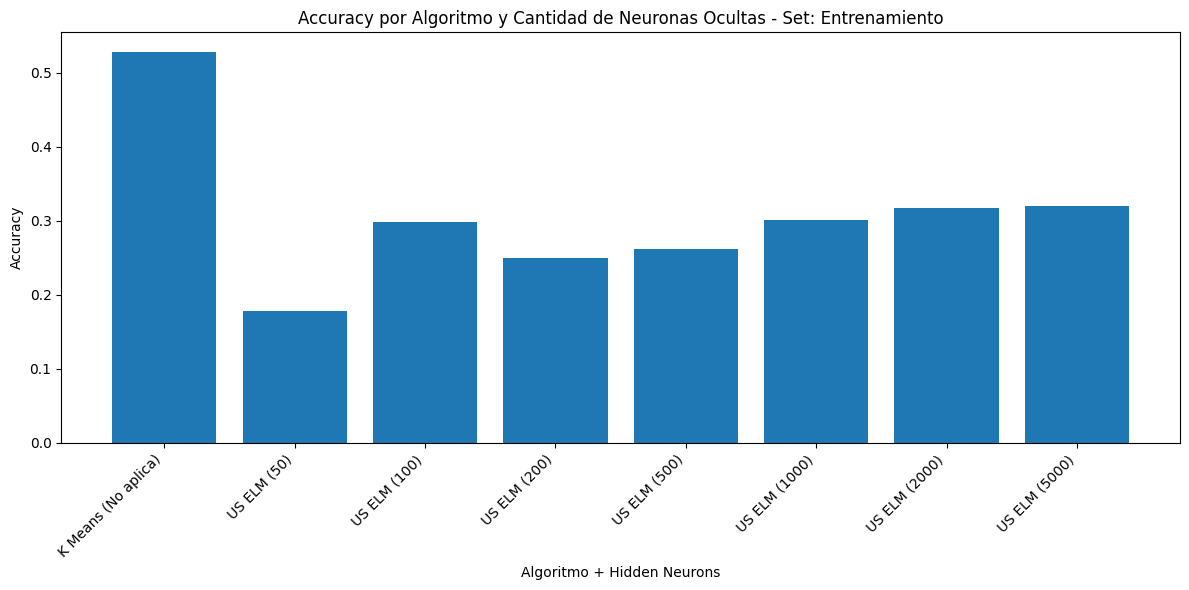

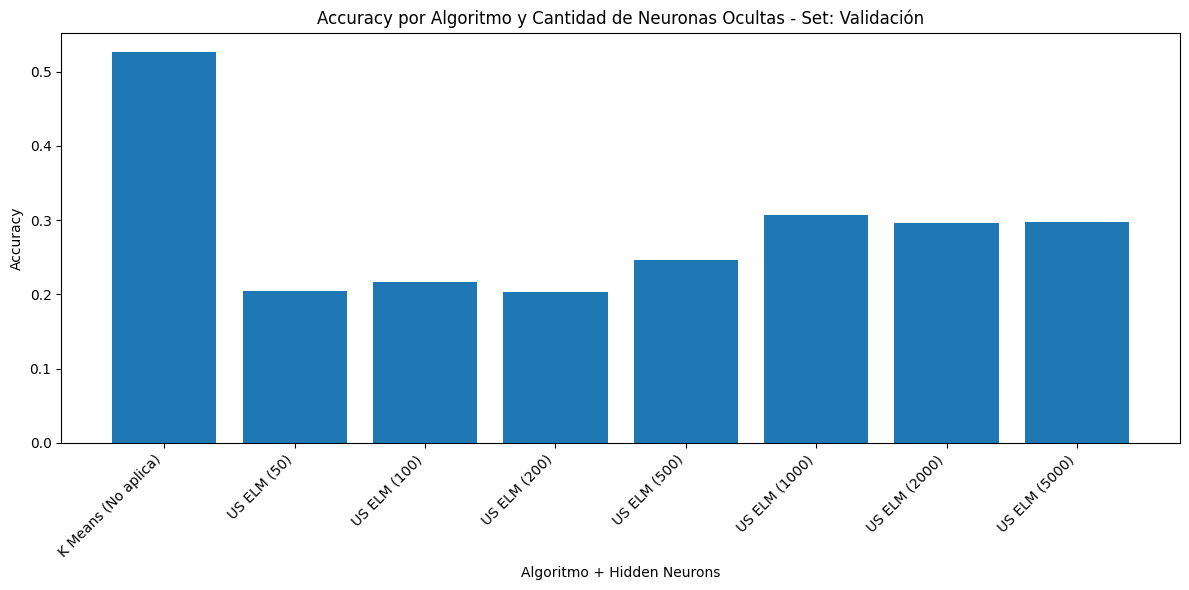

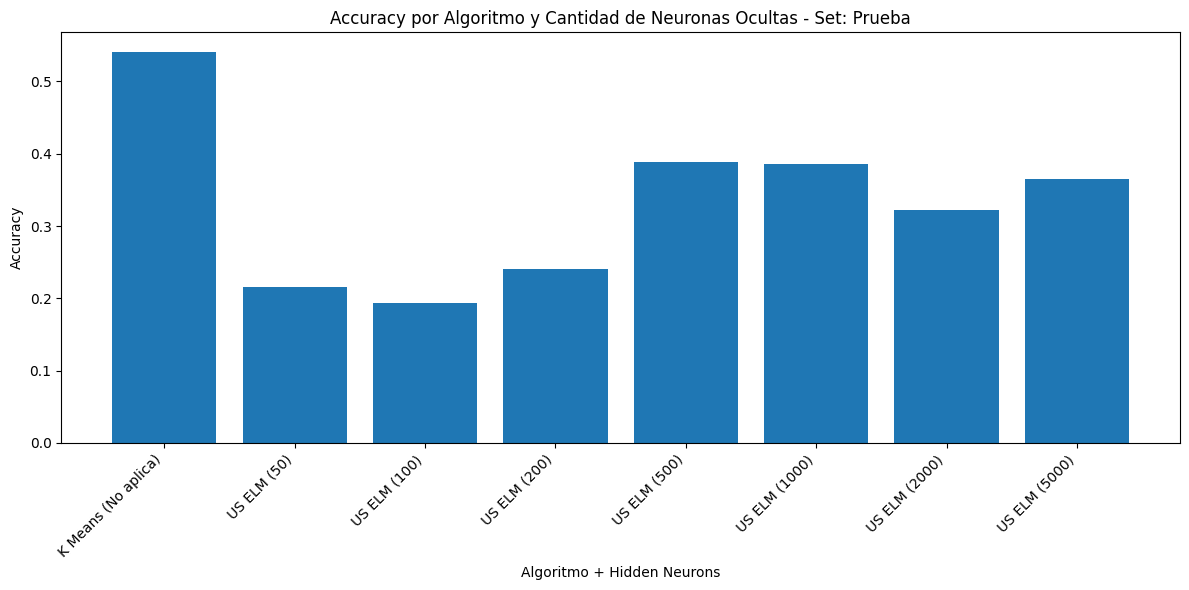

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Leer los datos desde el archivo CSV
file_path = "table.csv"
comparison_results_df = pd.read_csv(file_path)
print(comparison_results_df.columns)

# Filtrar los datos para cada dataset
datasets = ["Entrenamiento", "Validación", "Prueba"]
for dataset in datasets:
    # Filtrar los datos del dataset actual
    dataset_df = comparison_results_df[comparison_results_df["Dataset"] == dataset]

    # Crear la gráfica
    plt.figure(figsize=(12, 6))
    plt.bar(
        dataset_df["Algoritmo"] + " (" + dataset_df["Hidden Neurons"].astype(str) + ")",
        dataset_df["Accuracy"],
    )
    plt.title(f"Accuracy por Algoritmo y Cantidad de Neuronas Ocultas - Set: {dataset}")
    plt.xlabel("Algoritmo + Hidden Neurons")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()



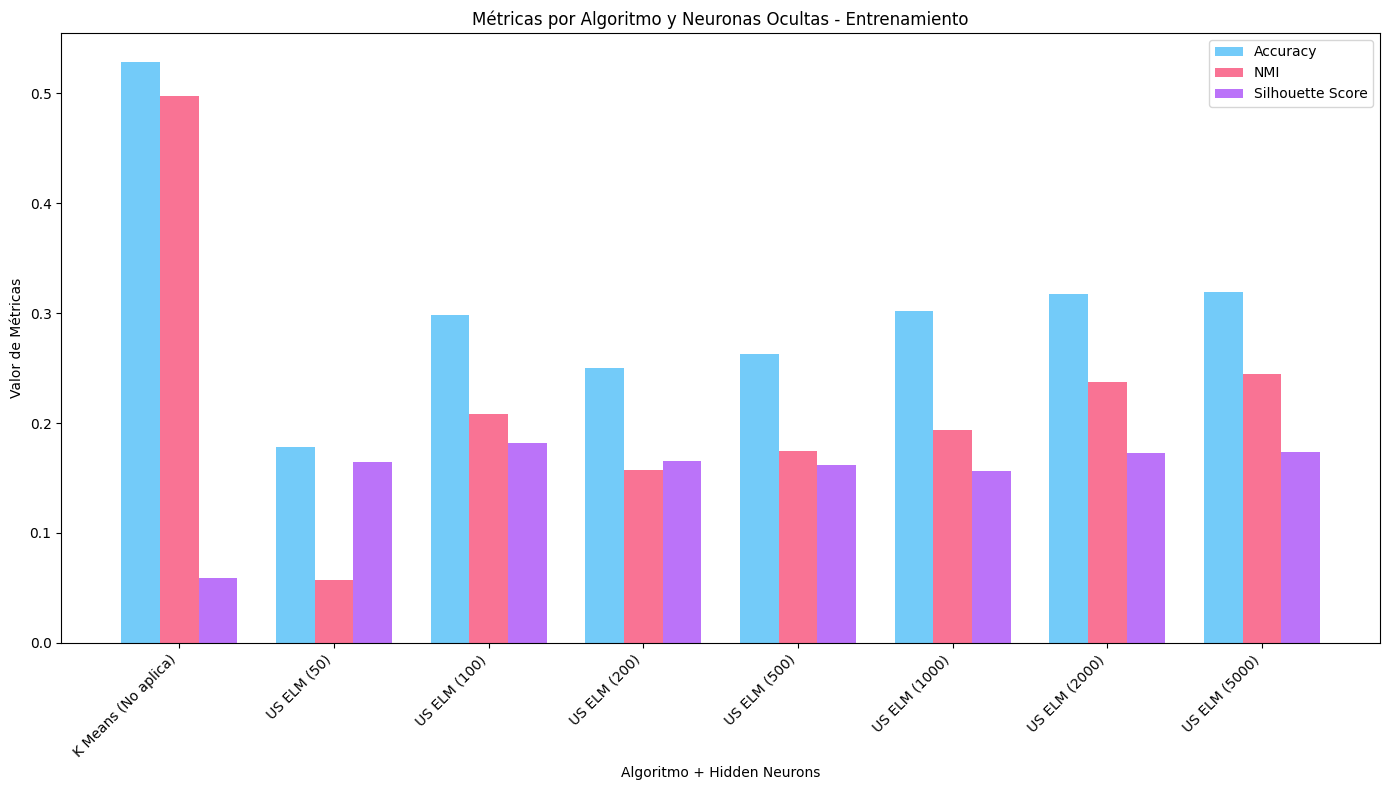

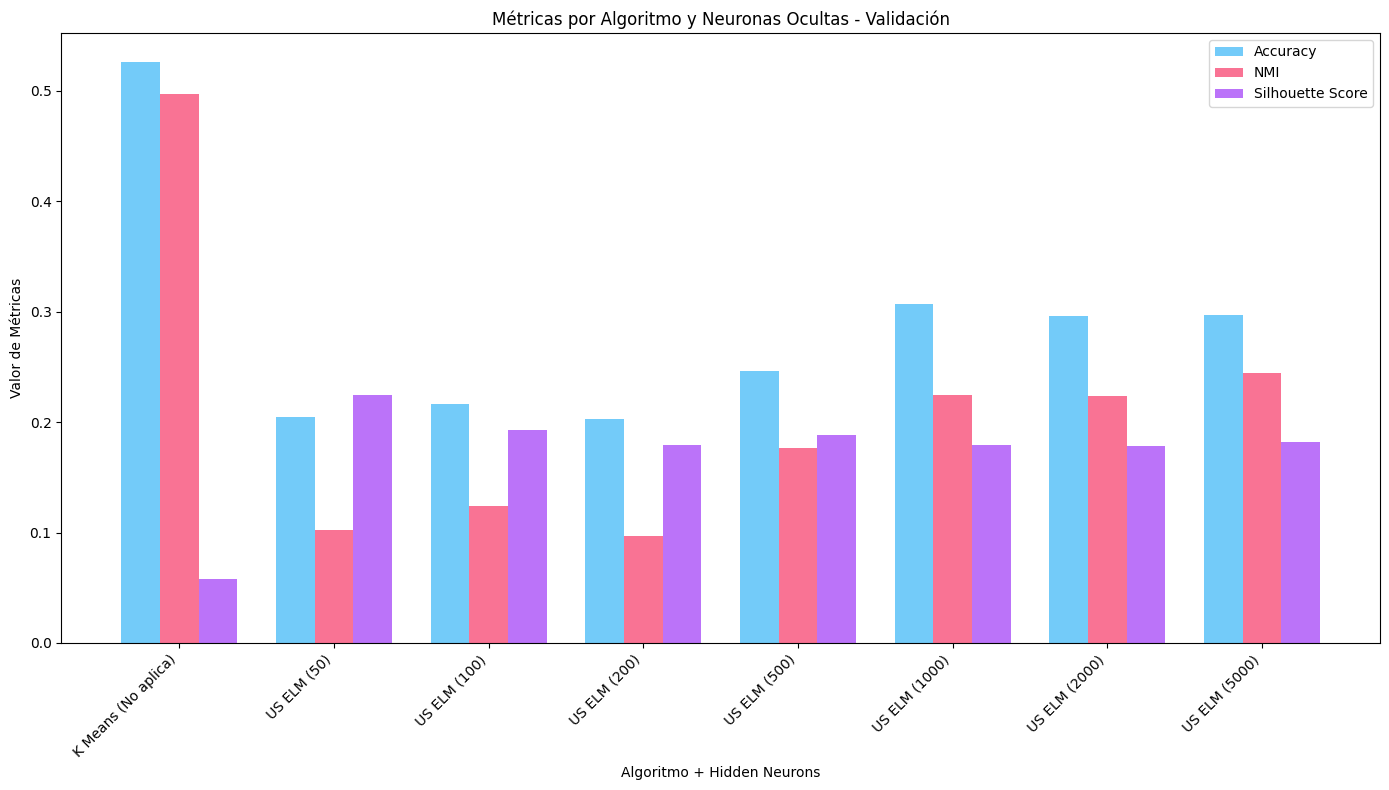

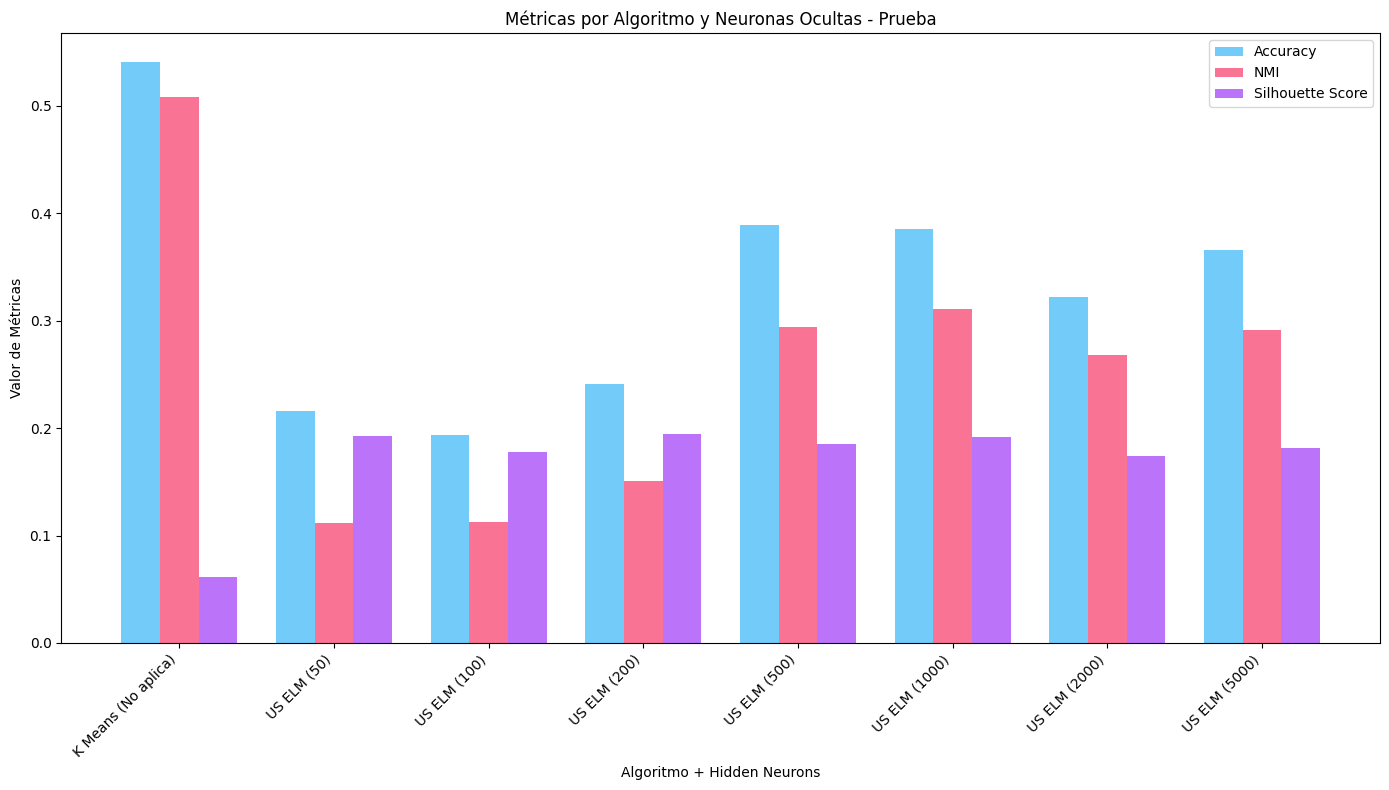

In [32]:
for dataset in datasets:
    # Filtrar los datos del dataset actual
    dataset_df = comparison_results_df[comparison_results_df["Dataset"] == dataset]

    # Configurar el ancho de las barras y la posición
    x_labels = dataset_df["Algoritmo"] + " (" + dataset_df["Hidden Neurons"].astype(str) + ")"
    x = np.arange(len(x_labels))  # Posiciones para las barras
    width = 0.25  # Ancho de las barras

    # Crear la gráfica
    plt.figure(figsize=(14, 8))
    plt.bar(x - width, dataset_df["Accuracy"], width=width, label="Accuracy", color="#73cbf9")
    plt.bar(x, dataset_df["NMI"], width=width, label="NMI", color="#f97394")
    plt.bar(x + width, dataset_df["Silhouette Score"], width=width, label="Silhouette Score", color="#bb73f9")

    # Configuración de la gráfica
    plt.title(f"Métricas por Algoritmo y Neuronas Ocultas - {dataset}")
    plt.xlabel("Algoritmo + Hidden Neurons")
    plt.ylabel("Valor de Métricas")
    plt.xticks(x, x_labels, rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()


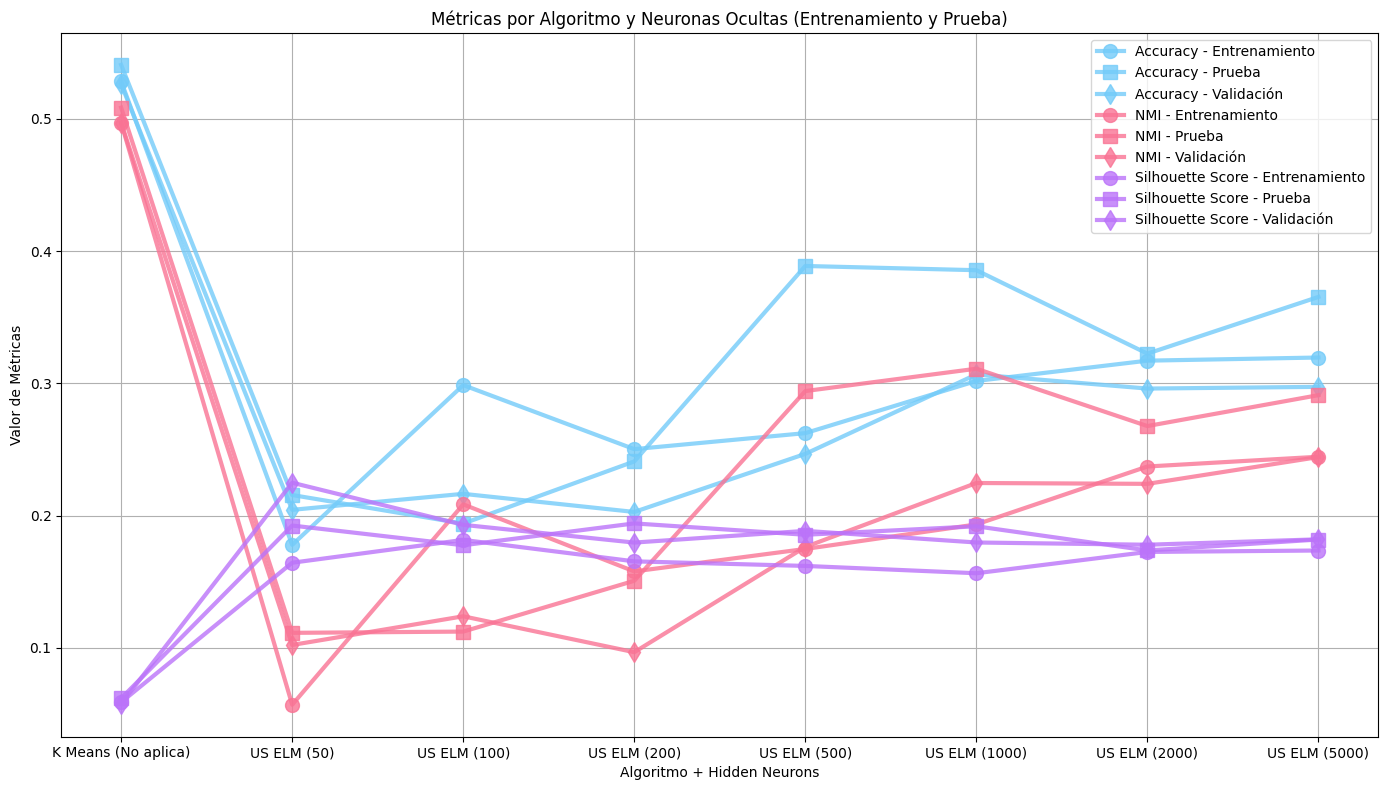

In [33]:
filtered_df = comparison_results_df[comparison_results_df["Dataset"].isin(datasets)]

# Configurar marcadores y colores para las métricas
markers = {"Entrenamiento": "o", "Prueba": "s", "Validación": "d"}
colors = {"Accuracy": "#73cbf9", "NMI": "#f97394", "Silhouette Score": "#bb73f9"}
marker_size = 10  # Tamaño del marcador

# Crear la gráfica
plt.figure(figsize=(14, 8))

# Iterar sobre los datasets y métricas
x_labels = (
    filtered_df[filtered_df["Dataset"] == "Entrenamiento"]["Algoritmo"]
    + " ("
    + filtered_df[filtered_df["Dataset"] == "Entrenamiento"]["Hidden Neurons"].astype(str)
    + ")"
)
x = np.arange(len(x_labels))

for metric, color in colors.items():
    for dataset, marker in markers.items():
        dataset_df = filtered_df[filtered_df["Dataset"] == dataset]

        # Graficar las líneas con marcadores más grandes
        plt.plot(
            x,
            dataset_df[metric].values,
            label=f"{metric} - {dataset}",
            marker=marker,
            markersize=marker_size,  # Tamaño del marcador
            color=color,
            linewidth=3,
            alpha=0.8,
        )

# Configuración de la gráfica
plt.title("Métricas por Algoritmo y Neuronas Ocultas (Entrenamiento y Prueba)")
plt.xlabel("Algoritmo + Hidden Neurons")
plt.ylabel("Valor de Métricas")
plt.xticks(x, x_labels)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

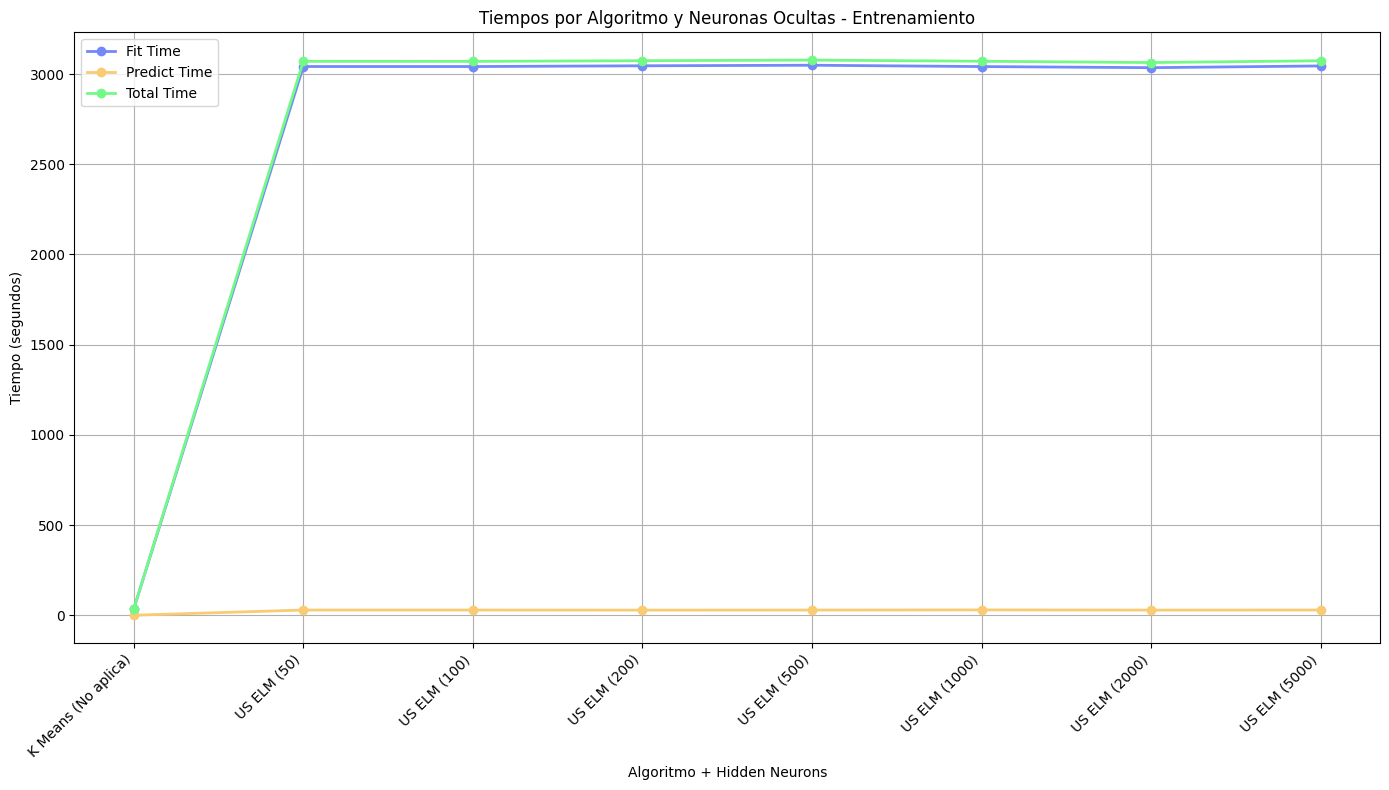

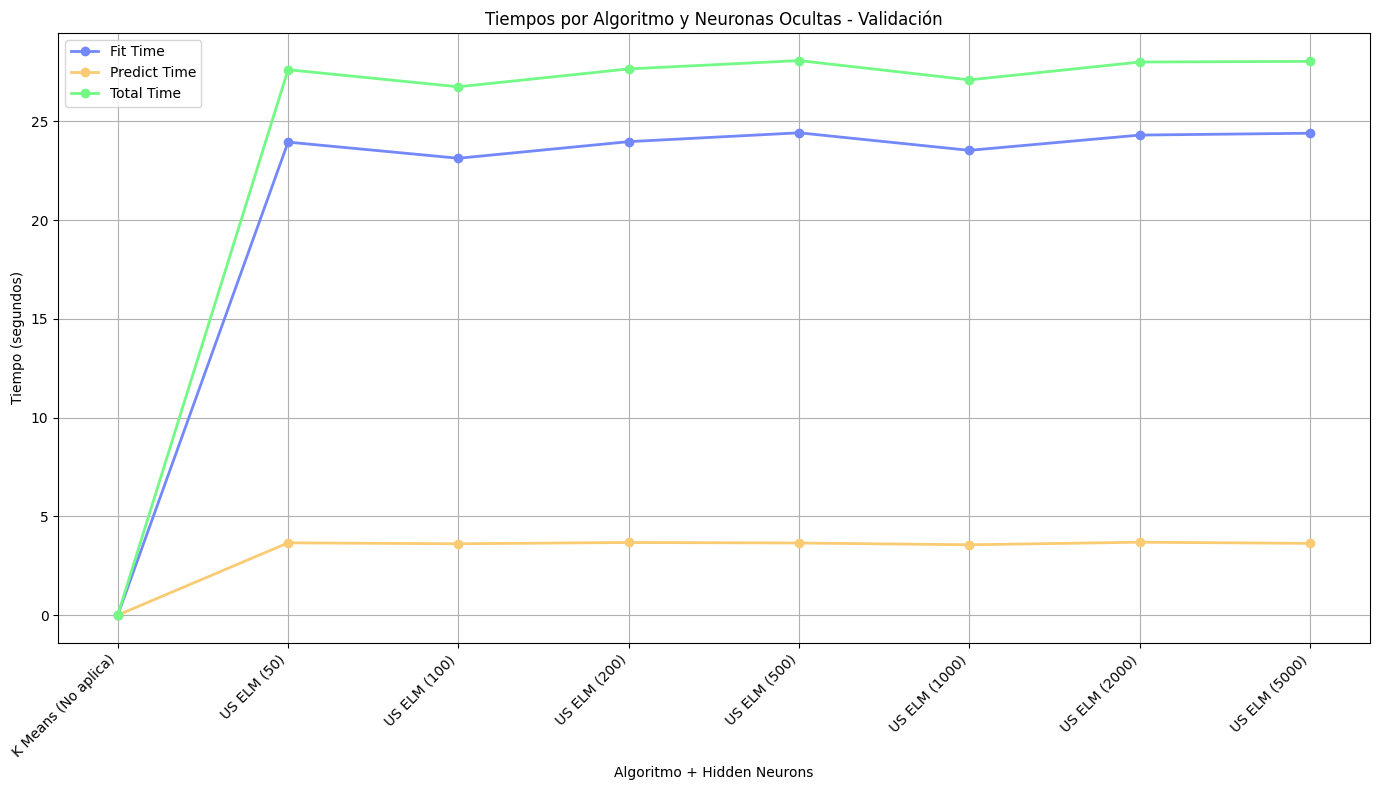

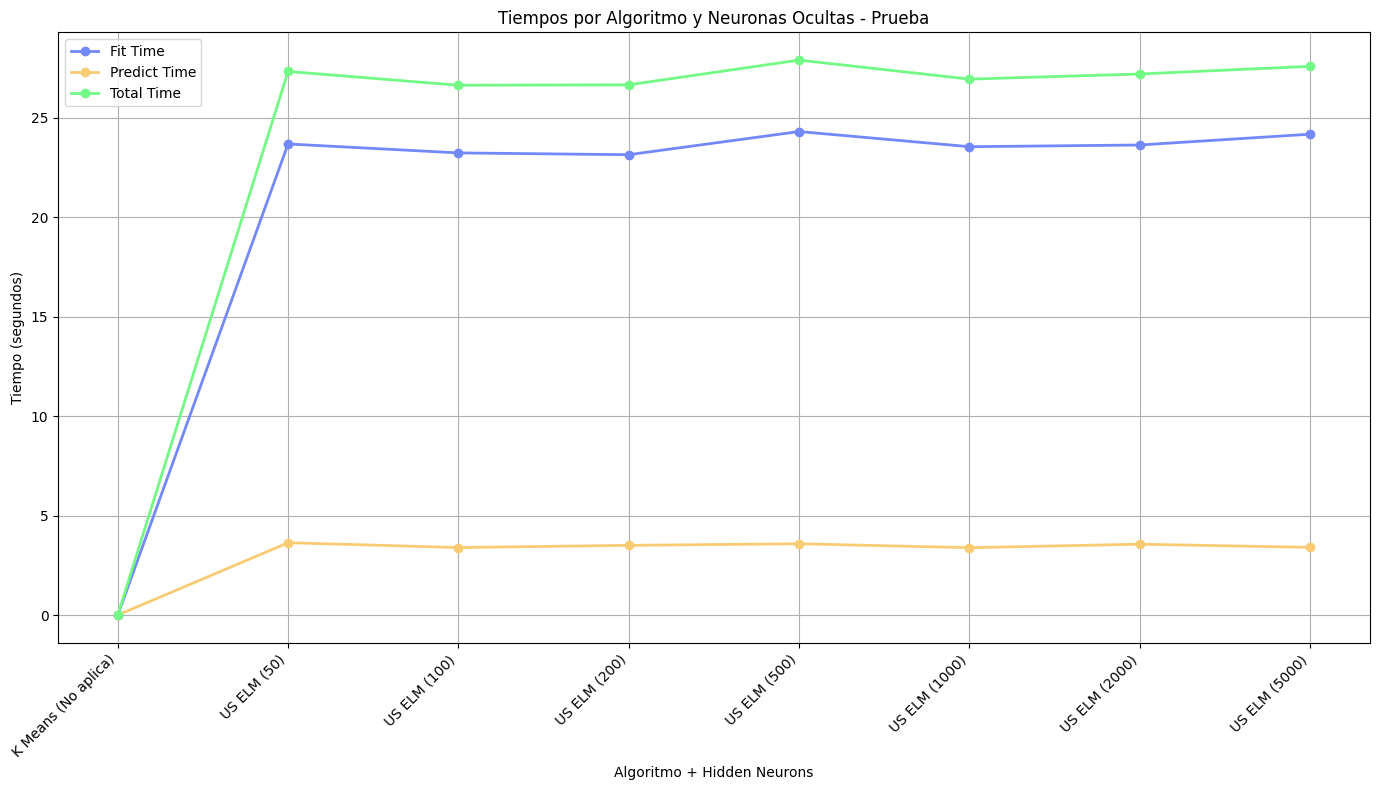

In [34]:
for dataset in datasets:
    # Filtrar los datos del dataset actual
    dataset_df = comparison_results_df[comparison_results_df["Dataset"] == dataset]

    # Configurar los datos para el gráfico
    x_labels = dataset_df["Algoritmo"] + " (" + dataset_df["Hidden Neurons"].astype(str) + ")"
    x = range(len(x_labels))  # Posiciones en el eje X

    # Crear el gráfico
    plt.figure(figsize=(14, 8))
    plt.plot(x, dataset_df["Fit Time"], label="Fit Time", marker="o", color="#7388f9", linewidth=2)
    plt.plot(x, dataset_df["Predict Time"], label="Predict Time", marker="o", color="#f9cb73", linewidth=2)
    plt.plot(x, dataset_df["Total Time"], label="Total Time", marker="o", color="#73f986", linewidth=2)

    # Configuración del gráfico
    plt.title(f"Tiempos por Algoritmo y Neuronas Ocultas - {dataset}")
    plt.xlabel("Algoritmo + Hidden Neurons")
    plt.ylabel("Tiempo (segundos)")
    plt.xticks(x, x_labels, rotation=45, ha="right")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

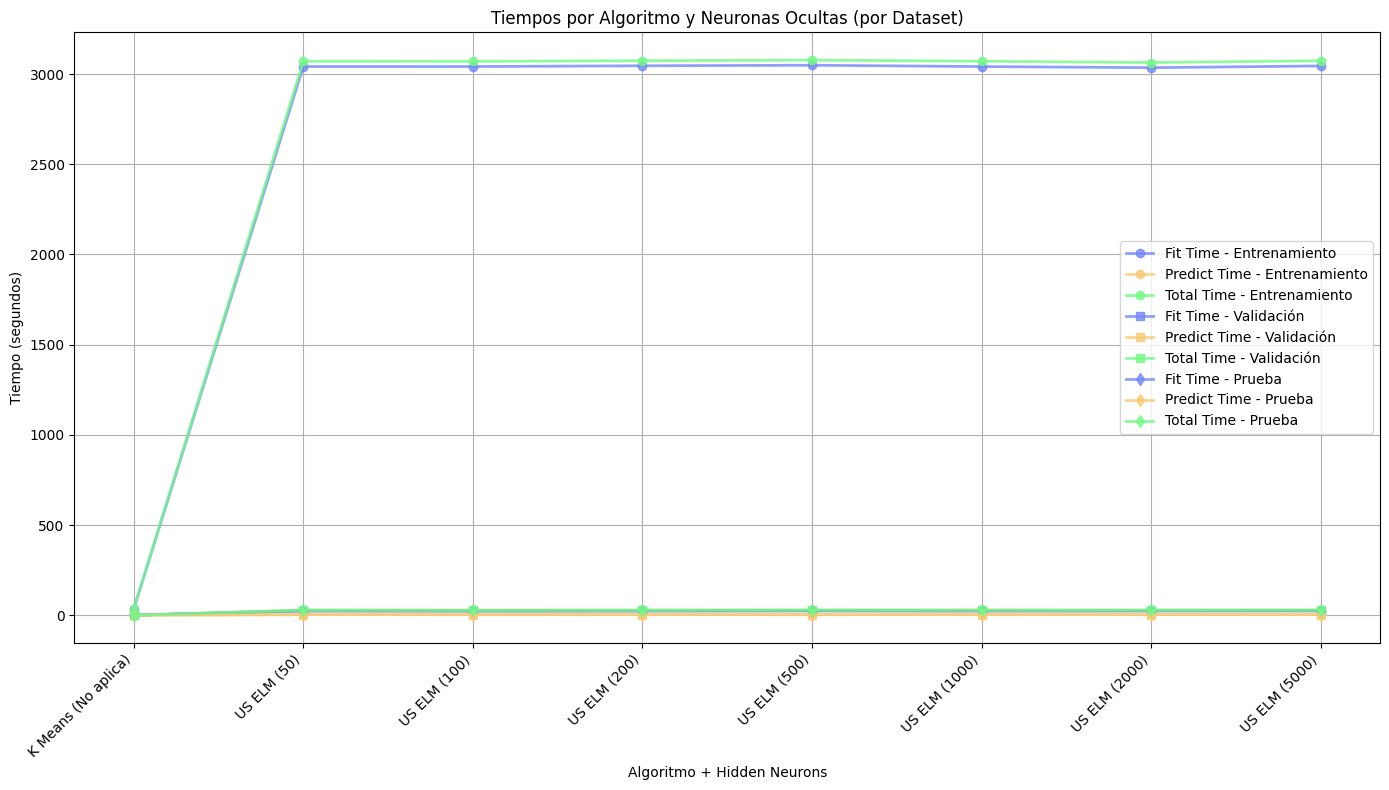

In [35]:
# Configurar los marcadores para cada dataset
markers = {"Entrenamiento": "o", "Validación": "s", "Prueba": "d"}
colors = {"Fit Time": "#7388f9", "Predict Time": "#f9cb73", "Total Time": "#73f986"}

# Crear el gráfico
plt.figure(figsize=(14, 8))

# Iterar sobre los datasets y métricas de tiempo
for dataset, marker in markers.items():
    dataset_df = comparison_results_df[comparison_results_df["Dataset"] == dataset]
    x_labels = dataset_df["Algoritmo"] + " (" + dataset_df["Hidden Neurons"].astype(str) + ")"
    x = range(len(x_labels))  # Posiciones en el eje X

    for metric, color in colors.items():
        plt.plot(
            x,
            dataset_df[metric],
            label=f"{metric} - {dataset}",
            marker=marker,
            color=color,
            linewidth=2,
            alpha=0.8,
        )

# Configuración del gráfico
plt.title("Tiempos por Algoritmo y Neuronas Ocultas (por Dataset)")
plt.xlabel("Algoritmo + Hidden Neurons")
plt.ylabel("Tiempo (segundos)")
plt.xticks(range(len(x_labels)), x_labels, rotation=45, ha="right")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


**Graficos de Entrenamiento y Prueba**

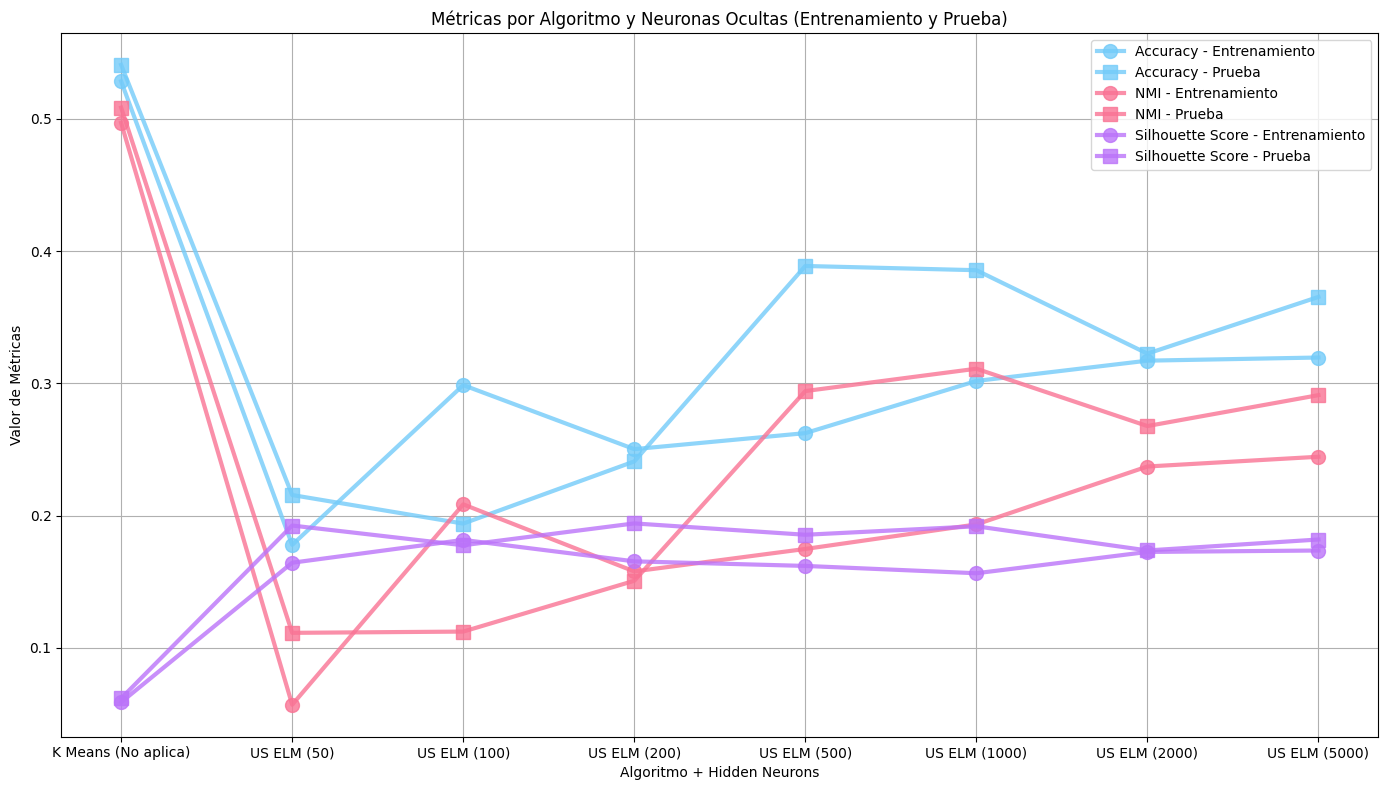

In [36]:
# Filtrar solo los datasets de Entrenamiento y Prueba
datasets = ["Entrenamiento", "Prueba"]
filtered_df = comparison_results_df[comparison_results_df["Dataset"].isin(datasets)]

# Configurar marcadores y colores para las métricas
markers = {"Entrenamiento": "o", "Prueba": "s"}
colors = {"Accuracy": "#73cbf9", "NMI": "#f97394", "Silhouette Score": "#bb73f9"}
marker_size = 10  # Tamaño del marcador

# Crear la gráfica
plt.figure(figsize=(14, 8))

# Iterar sobre los datasets y métricas
x_labels = (
    filtered_df[filtered_df["Dataset"] == "Entrenamiento"]["Algoritmo"]
    + " ("
    + filtered_df[filtered_df["Dataset"] == "Entrenamiento"]["Hidden Neurons"].astype(str)
    + ")"
)
x = np.arange(len(x_labels))

for metric, color in colors.items():
    for dataset, marker in markers.items():
        dataset_df = filtered_df[filtered_df["Dataset"] == dataset]

        # Graficar las líneas con marcadores más grandes
        plt.plot(
            x,
            dataset_df[metric].values,
            label=f"{metric} - {dataset}",
            marker=marker,
            markersize=marker_size,  # Tamaño del marcador
            color=color,
            linewidth=3,
            alpha=0.8,
        )

# Configuración de la gráfica
plt.title("Métricas por Algoritmo y Neuronas Ocultas (Entrenamiento y Prueba)")
plt.xlabel("Algoritmo + Hidden Neurons")
plt.ylabel("Valor de Métricas")
plt.xticks(x, x_labels)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

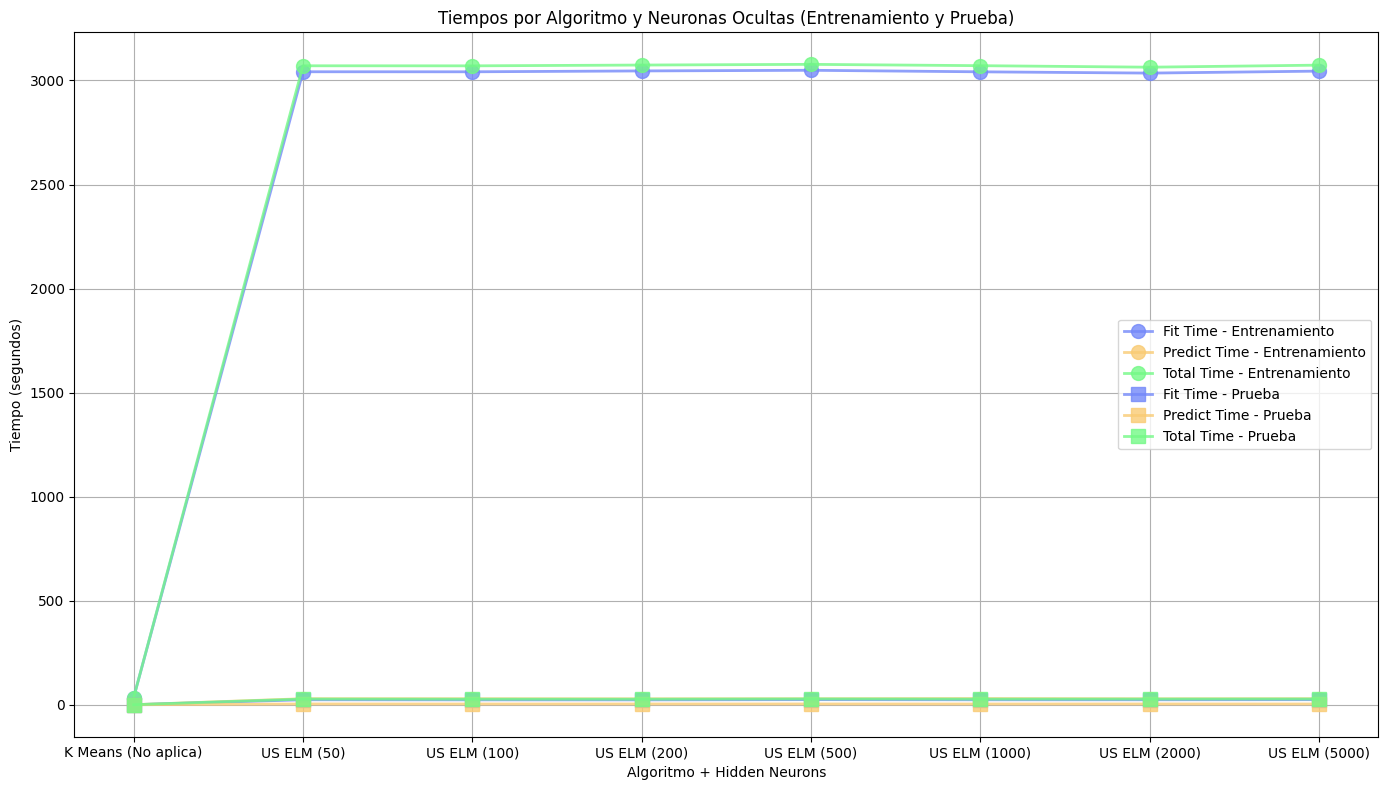

In [37]:
# Configurar los marcadores y colores para Entrenamiento y Prueba
markers = {"Entrenamiento": "o", "Prueba": "s"}
colors = {"Fit Time": "#7388f9", "Predict Time": "#f9cb73", "Total Time": "#73f986"}
marker_size = 10  # Tamaño del marcador

# Crear el gráfico
plt.figure(figsize=(14, 8))

# Filtrar los datasets seleccionados
datasets = ["Entrenamiento", "Prueba"]

# Iterar sobre los datasets y métricas de tiempo
for dataset, marker in markers.items():
    dataset_df = comparison_results_df[comparison_results_df["Dataset"] == dataset]
    x_labels = dataset_df["Algoritmo"] + " (" + dataset_df["Hidden Neurons"].astype(str) + ")"
    x = range(len(x_labels))  # Posiciones en el eje X

    for metric, color in colors.items():
        plt.plot(
            x,
            dataset_df[metric],
            label=f"{metric} - {dataset}",
            marker=marker,
            markersize=marker_size,  # Tamaño del marcador
            color=color,
            linewidth=2,
            alpha=0.8,
        )

# Configuración del gráfico
plt.title("Tiempos por Algoritmo y Neuronas Ocultas (Entrenamiento y Prueba)")
plt.xlabel("Algoritmo + Hidden Neurons")
plt.ylabel("Tiempo (segundos)")
plt.xticks(range(len(x_labels)), x_labels) #, rotation=45, ha="right"
plt.legend()
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


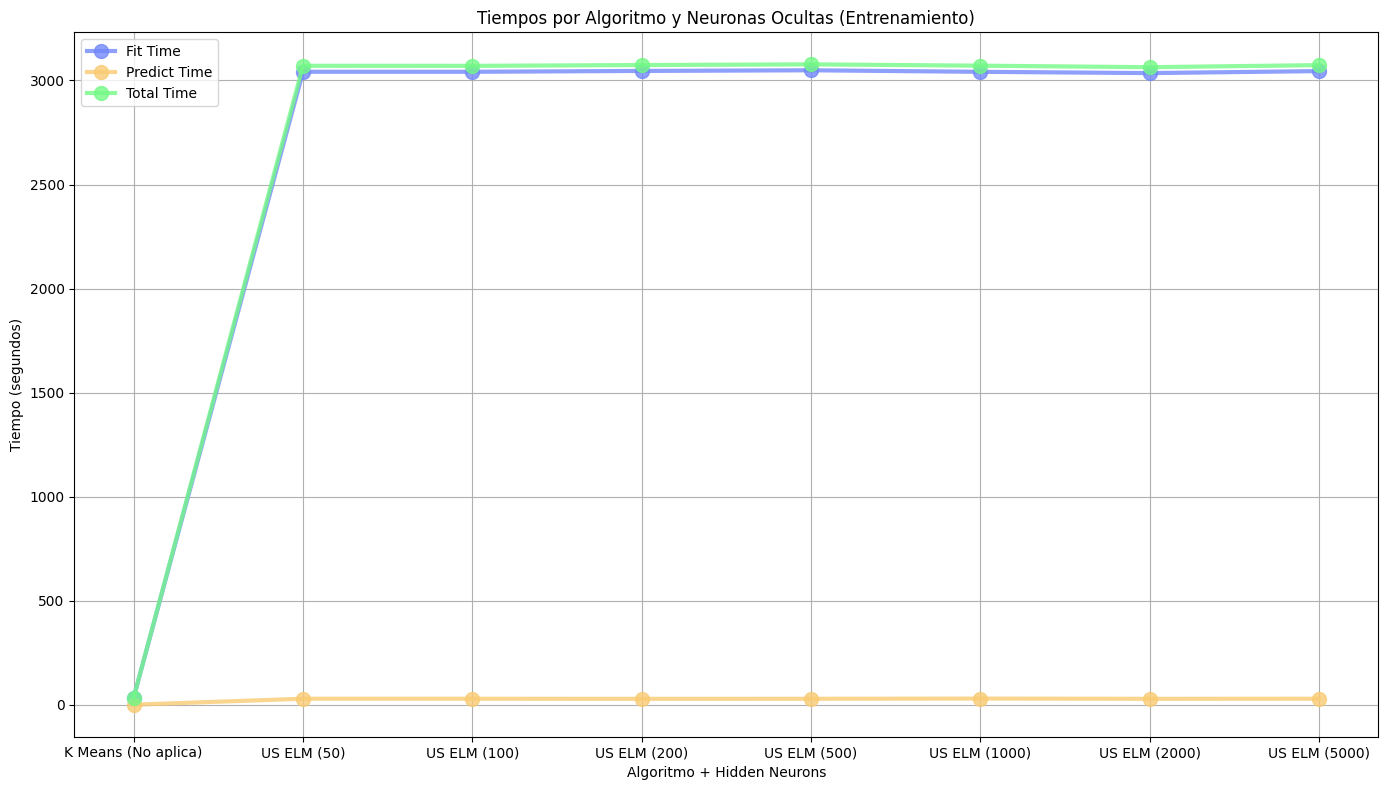

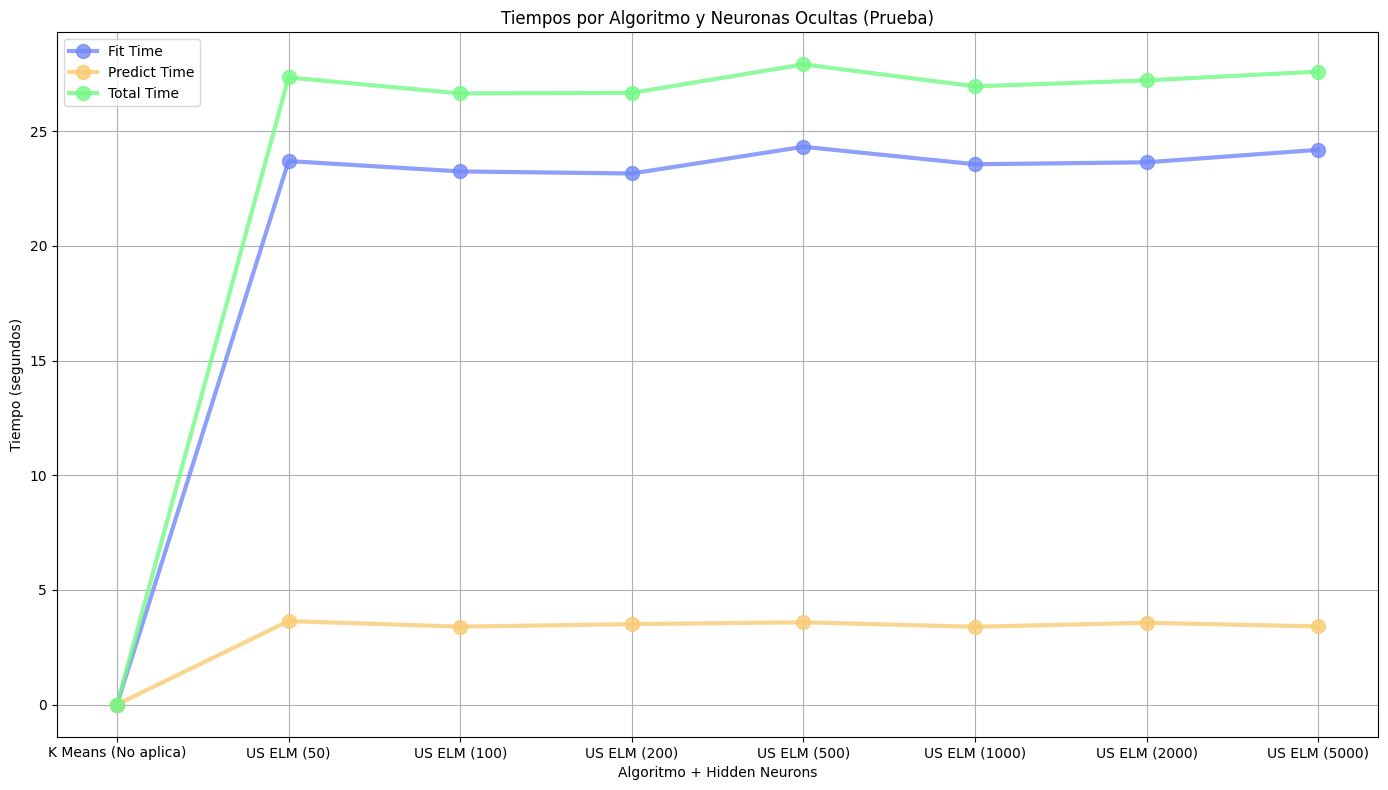

In [38]:
# Filtrar los datasets seleccionados
datasets = ["Entrenamiento", "Prueba"]

# Crear un gráfico separado para cada dataset
for dataset in datasets:
    dataset_df = comparison_results_df[comparison_results_df["Dataset"] == dataset]
    x_labels = dataset_df["Algoritmo"] + " (" + dataset_df["Hidden Neurons"].astype(str) + ")"
    x = range(len(x_labels))  # Posiciones en el eje X

    # Crear el gráfico
    plt.figure(figsize=(14, 8))

    for metric, color in colors.items():
        plt.plot(
            x,
            dataset_df[metric],
            label=f"{metric}",
            marker="o",
            markersize=marker_size,  # Tamaño del marcador
            color=color,
            linewidth=3,
            alpha=0.8,
        )

    # Configuración del gráfico
    plt.title(f"Tiempos por Algoritmo y Neuronas Ocultas ({dataset})")
    plt.xlabel("Algoritmo + Hidden Neurons")
    plt.ylabel("Tiempo (segundos)")
    plt.xticks(range(len(x_labels)), x_labels)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()